<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Балансировка-данных" data-toc-modified-id="Балансировка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Балансировка данных</a></span><ul class="toc-item"><li><span><a href="#Уменьшение-размера-весов-классов" data-toc-modified-id="Уменьшение-размера-весов-классов-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Уменьшение размера весов классов</a></span></li><li><span><a href="#Ресемплинг-с-уменшением-класса-0" data-toc-modified-id="Ресемплинг-с-уменшением-класса-0-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Ресемплинг с уменшением класса 0</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Классификатор-LogisticRegression" data-toc-modified-id="Классификатор-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Классификатор LogisticRegression</a></span></li><li><span><a href="#Классификатор-DecisionTreeClassifier" data-toc-modified-id="Классификатор-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор DecisionTreeClassifier</a></span></li><li><span><a href="#Классификатор-CatBoostClassifier" data-toc-modified-id="Классификатор-CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Классификатор CatBoostClassifier</a></span></li><li><span><a href="#Вывод-по-классификаторам" data-toc-modified-id="Вывод-по-классификаторам-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод по классификаторам</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install imbalanced-learn

     |████████████████████████████████| 258 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 55.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 82.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

In [3]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
toxic_comments.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


В данных присутствует колонка с нумерацией, которая не соответствует истинной нумерации с какого-то момента. Так как она не информативна, можно её просто дропнуть.

In [6]:
toxic_comments = toxic_comments.drop(columns=['Unnamed: 0'])

In [7]:
toxic_comments

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [8]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
#Посмотрим сколько у нас токсичных/нектоксичных текстов
display(toxic_comments['toxic'].value_counts())
#Выведем соотношение
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

**Вывод**

Видим что классы несбалансированы, применем несколько спомобов балансировки и сравним их

In [10]:
#lemmatizer = WordNetLemmatizer()

# Загрузка необходимых данных из nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

# Функция для преобразования POS-тегов
#def get_wordnet_pos(tag):
   # if tag.startswith('J'):
    #    return wordnet.ADJ
   # elif tag.startswith('V'):
      #  return wordnet.VERB
    #elif tag.startswith('N'):
       # return wordnet.NOUN
   # elif tag.startswith('R'):
        #return wordnet.ADV
    #else:
        #return wordnet.NOUN

#def lemmatize_text(text):
   # text = text.lower()
    #lemm_text = "".join(lemmatizer.lemmatize(text))
   # cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
   # return " ".join(cleared_text.split())


#toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)

#toxic_comments = toxic_comments.drop(['text'], axis=1)

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Функция для преобразования POS-тегов
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Исправленная функция для лемматизации текста
def lemmatize_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    cleared_text = re.sub(r'[^a-zA-Z\s]', '', ' '.join(lemmatized_tokens))  # Удаление всех символов, кроме букв и пробелов
    return ' '.join(cleared_text.split())

# Применение лемматизации к тексту в DataFrame
toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)

# Удаление исходного текста
toxic_comments = toxic_comments.drop(['text'], axis=1)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
toxic_comments

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,daww he match this background colour i m seemi...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i ca nt make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...
...,...,...
159287,0,and for the second time of ask when your view ...
159288,0,you should be ashamed of yourself that be a ho...
159289,0,spitzer umm theres no actual article for prost...
159290,0,and it look like it be actually you who put on...


In [13]:
# Разделение данных
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target, 
    test_size=0.5, 
    random_state=1515
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, 
    target_valid, 
    test_size=0.5,
    random_state=1515
)

# Загрузка стоп-слов
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

# Применение TF-IDF векторизации
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_valid = count_tf_idf.transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

# Уменьшение количества кросс-валидаций до 3
cv_counts = 3

# Кросс-валидация с downsampling
skf = StratifiedKFold(n_splits=cv_counts)
model = LogisticRegression(max_iter=1000)
rus = RandomUnderSampler(random_state=12082020)

accuracies = []
f1_scores = []

for train_index, val_index in skf.split(features_train, target_train):
    X_train_fold, X_val_fold = features_train[train_index], features_train[val_index]
    y_train_fold, y_val_fold = target_train.iloc[train_index], target_train.iloc[val_index]
    
    X_res, y_res = rus.fit_resample(X_train_fold, y_train_fold)
    
    model.fit(X_res, y_res)
    y_pred = model.predict(X_val_fold)
    
    accuracy = accuracy_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred, average='macro')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    
    print(f"Fold accuracy: {accuracy}")
    print(f"Fold F1 score: {f1}")

print(f"Mean accuracy: {sum(accuracies) / len(accuracies)}")
print(f"Mean F1 score: {sum(f1_scores) / len(f1_scores)}")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(79646, 122556)
(39823, 122556)
(39823, 122556)
Fold accuracy: 0.918754002033975
Fold F1 score: 0.8139041718643808
Fold accuracy: 0.9155523748540435
Fold F1 score: 0.8102195137006514
Fold accuracy: 0.9190146150369143
Fold F1 score: 0.8158173128924977
Mean accuracy: 0.9177736639749776
Mean F1 score: 0.81331366615251


### Балансировка данных

#### Уменьшение размера весов классов

In [14]:
dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7408047783681236


In [15]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7408047783681236


#### Ресемплинг с уменшением класса 0

In [16]:
#toxic_comments_train = toxic_comments.iloc[target_train.index]

#target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
#target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [17]:
#target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    #random_state=12082020)
#target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

#features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
#features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             #target_train_downsample,
                                                             #random_state=12082020)
#features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'])

In [18]:
# Переписанный код
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),  # Преобразование текста в TF-IDF
    ('undersample', RandomUnderSampler(random_state=12082020)),  # Балансировка классов
    ('classifier', LogisticRegression(random_state=12082020, max_iter=1000))])  # Классификатор


In [19]:
features_train_0, features_test_0, target_train_0, target_test_0 = train_test_split(
    toxic_comments['lemm_text'], 
    toxic_comments['toxic'], 
    test_size=0.2, 
    random_state=42
)

In [20]:
cv_counts = 3

In [21]:
scores = cross_val_score(pipeline, features_train_0, target_train_0, cv=cv_counts, scoring='f1')
print("Среднее значение F1-метрики: ", scores.mean())

Среднее значение F1-метрики:  0.6692930548268117


In [22]:
# Оценка модели на тестовом наборе данных
#pipeline.fit(features_train_0, target_train_0)
#test_accuracy = pipeline.score(features_test_0, target_test_0)
#print("Accuracy на тестовом наборе данных: ", test_accuracy)

F1 мера повысилась.

**Вывод**

1) В ходе подготовки данных мы получили признаки для обучения, получили обучающую, валидационную и тестовую выборку.

2) По итогу балансировки данных стало понятно, что баланс по весам самый оптимальный, с ним и работаем дальше

## Обучение

### Классификатор LogisticRegression

In [23]:
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}

Grid scores on development set:

0.703002 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.704696 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.702889 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.742965 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.740805 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.742722 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.750433 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.748618 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.750635 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver

In [24]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7506353118322439
F1 на валидации 0.75


### Классификатор DecisionTreeClassifier

In [25]:
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[1515],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 98, 'random_state': 1515}

Grid scores on development set:

0.632677 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 50, 'random_state': 1515}
0.628436 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 52, 'random_state': 1515}
0.633041 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 54, 'random_state': 1515}
0.633800 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 56, 'random_state': 1515}
0.633711 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 58, 'random_state': 1515}
0.626381 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 60, 'random_state': 1515}
0.627589 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 62, 'random_state': 1515}
0.624597 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 64, 'random_state': 1515}
0

In [26]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.640346969572347
F1 на валидации 0.6198681623684514


### Классификатор CatBoostClassifier

In [27]:
classificator = CatBoostClassifier(verbose=False, iterations=250)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.719469903991163
F1 на валидации 0.7301261366969786


### Вывод по классификаторам

In [28]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.750635,0.750000,False
DecisionTreeClassifier,0.640347,0.619868,False
CatBoostClassifier,0.719470,0.730126,False


**Вывод**

К тестовому набору данных перейдут LogisticRegression

## Выводы

Метрики LogisticRegression
ROC AUC: 0.9619690997849141
F1: 0.7550753888163362
Precision: 0.726027397260274
Recall: 0.7865446450655453
Accuracy: 0.9481957662657259



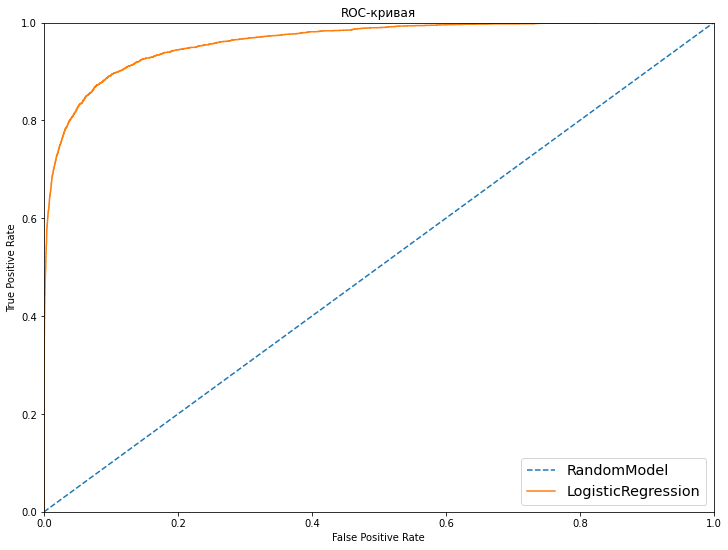

In [29]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

# Вывод
Было прделано:
1) Подготовленны данные обучения.

2) Выбран способ баланса классов, сформированы обучающая, валидационная и тестовая выборка.

3) Обучены модели и выбрана лучшая из них на валидационной выборке.

4) Показаны параметры качества моделей.

**Исходные данные обладают большим количеством признаков.** Созданных столбцов больше, чем записей данных. Лучшая модель стала LogisticRegression. 

**CatBoostClassifier может показать себя очень хорошо при долгом обучении на данных.** 